In [1]:
# Useful imports
import numpy as np
from matplotlib.pyplot import figure, show
from photutils import aperture as ap
from astropy.io import fits
from astropy.time import Time
from pathlib import Path
from scipy.stats import chisquare
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Sorts images by frame number

# path to reduced data
path = "/net/virgo01/data/users/mpucovsky/OAProject/2025-05-05/Reduced"
pathObj = Path(path)

frames = {}
for f in pathObj.iterdir():
    name = f.name
    if "Star" not in name and "Flat" not in name and ".fit" in name:
        hduList = fits.open(f)
        data = hduList[0].data
        data -= np.nanmedian(data) # global background correction
        frames[name] = data
        hduList.close()
        
orderedFrames = dict(sorted(frames.items()))

In [3]:
# Defines apertures and annuli
# checking stars got changed often - sorry for confusing variable names

targetAp = ap.CircularAperture((650,602), 6)
targetAn = ap.CircularAnnulus((650,602), 8, 15)

# checking star candidate 5
check1Ap = ap.CircularAperture((554,553), 5)
check1An = ap.CircularAnnulus((554,553), 7, 15)

# checking star candidate 3
check2Ap2 = ap.CircularAperture((680,622), 6)
check2An2 = ap.CircularAnnulus((680,622), 8, 18)

# checking star 4
check2Ap3 = ap.CircularAperture((768,617), 4)
check2An3 = ap.CircularAnnulus((768,617), 6, 14)

# checking star 6
check2Ap4 = ap.CircularAperture((659,586), 6)
check2An4 = ap.CircularAnnulus((659,586), 7, 12)

In [4]:
# Finds counts for each star

def FindCounts(data):    
    # background for target
    tAnStats = ap.ApertureStats(data, targetAn)
    tBackground = tAnStats.median
    # counts for target
    tApStats = ap.ApertureStats(data, targetAp)
    tCounts = tApStats.sum - (tApStats.sum_aper_area.value*tBackground)
    
    # background for checking1
    c1AnStats = ap.ApertureStats(data, check1An)
    c1Background = c1AnStats.median
    # counts for checking1
    c1ApStats = ap.ApertureStats(data, check1Ap)
    c1Counts = c1ApStats.sum - (c1ApStats.sum_aper_area.value*c1Background)
    
    # background for checking2
    c2AnStats = ap.ApertureStats(data, check2An2)
    c2Background = c2AnStats.median
    # counts for checking2
    c2ApStats = ap.ApertureStats(data, check2Ap2)
    c2Counts = c2ApStats.sum - (c2ApStats.sum_aper_area.value*c2Background)
    
    return [tCounts, c1Counts, c2Counts]

# each contains tuples [target, checking1, checking2]
R = []
G = []
B = []
Lum = []

for file in orderedFrames:
    if "R" in file[8:]:
        R.append(FindCounts(orderedFrames[file]))
    if "G" in file[8:]:
        G.append(FindCounts(orderedFrames[file]))
    if "B" in file[8:]:
        B.append(FindCounts(orderedFrames[file]))
    if "Lum" in file[8:]:
        Lum.append(FindCounts(orderedFrames[file]))

In [5]:
# finds timestamps of each frame
RT = []
GT = []
BT = []
LumT = []
for file in orderedFrames:
    hduList = fits.open(path+"/"+file)
    head = hduList[0].header
    JD = head["JD"]
    time = Time(JD, format="jd", scale="ut1")
    time.format = 'iso'
    t = time.value[11:19]
    if "00" in t[0:2]:
        t = "24"+t[2:]
    if "R" in file[8:]:
        RT.append(t)
    if "G" in file[8:]:
        GT.append(t)
    if "B" in file[8:]:
        BT.append(t)
    if "Lum" in file[8:]:
        LumT.append(t)
    hduList.close()

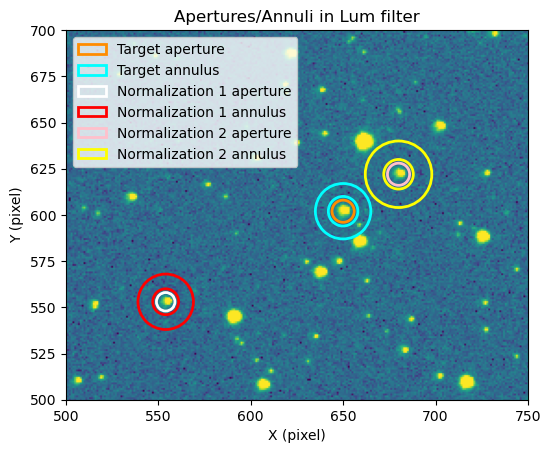

In [6]:
# quick image plot to check apertures and annuli for all 4 filters

from photutils.datasets import make_100gaussians_image
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
data = orderedFrames["Reduced_0001_Lum3.fit"]
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation=None,origin="lower")
plt.title("Apertures/Annuli in Lum filter")
plt.xlabel("X (pixel)")
plt.ylabel("Y (pixel)")
plt.xlim(500, 750)
plt.ylim(500, 700)
ap_patches = targetAp.plot(color='darkorange', lw=2,label='Target aperture'),
targetAn.plot(color='cyan', lw=2, label='Target annulus'),
check1Ap.plot(color='white', lw=2,label='Normalization 1 aperture'),
check1An.plot(color='red', lw=2, label='Normalization 1 annulus'),
check2Ap2.plot(color='pink', lw=2,label='Normalization 2 aperture'),
check2An2.plot(color='yellow', lw=2, label='Normalization 2 annulus')
plt.legend()
handles = (ap_patches[0])


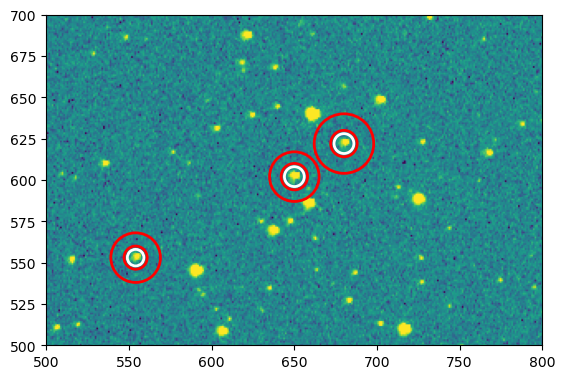

In [7]:
# B filter

data = orderedFrames["Reduced_0001_B3.fit"]
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation=None)
plt.xlim(500, 800)
plt.ylim(500, 700)
ap_patches = targetAp.plot(color='white', lw=2,label='Photometry aperture'),
check1Ap.plot(color='white', lw=2,label='Photometry aperture'),

check2Ap2.plot(color='white', lw=2,label='Photometry aperture')
ann_patches = targetAn.plot(color='red', lw=2, label='Background annulus'),
check1An.plot(color='red', lw=2, label='Background annulus'),

check2An2.plot(color='red', lw=2, label='Background annulus')
handles = (ap_patches[0], ann_patches[0])



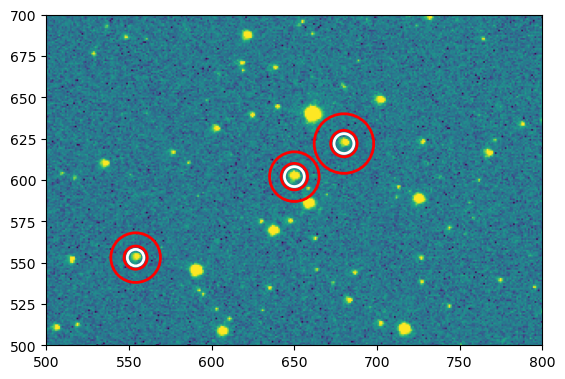

In [8]:
# R filter

data = orderedFrames["Reduced_0001_R3.fit"]
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation=None)
plt.xlim(500, 800)
plt.ylim(500, 700)
ap_patches = targetAp.plot(color='white', lw=2,label='Photometry aperture'),
check1Ap.plot(color='white', lw=2,label='Photometry aperture'),

check2Ap2.plot(color='white', lw=2,label='Photometry aperture')
ann_patches = targetAn.plot(color='red', lw=2, label='Background annulus'),
check1An.plot(color='red', lw=2, label='Background annulus'),

check2An2.plot(color='red', lw=2, label='Background annulus')
handles = (ap_patches[0], ann_patches[0])



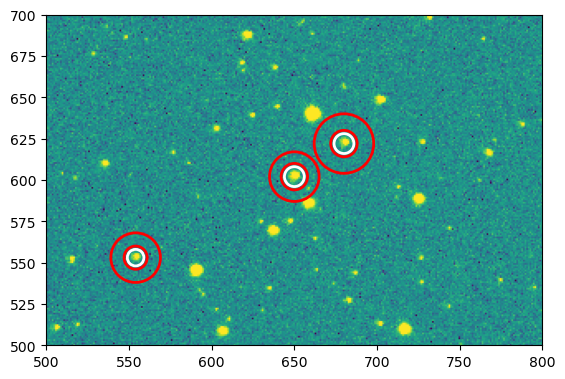

In [9]:
# G filter

data = orderedFrames["Reduced_0001_G3.fit"]
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation=None)
plt.xlim(500, 800)
plt.ylim(500, 700)
ap_patches = targetAp.plot(color='white', lw=2,label='Photometry aperture'),
check1Ap.plot(color='white', lw=2,label='Photometry aperture'),

check2Ap2.plot(color='white', lw=2,label='Photometry aperture')
ann_patches = targetAn.plot(color='red', lw=2, label='Background annulus'),
check1An.plot(color='red', lw=2, label='Background annulus'),

check2An2.plot(color='red', lw=2, label='Background annulus')
handles = (ap_patches[0], ann_patches[0])

In [10]:
# normalises counts using checking star 1

# each contains [normalised Target, normalised Checking 2]
normR = []
normG = []
normB = []
normLum = []

for i in range(0, len(R)):
    normR.append([R[i][0]/R[i][1],R[i][2]/R[i][1]])
    normG.append([G[i][0]/G[i][1],G[i][2]/G[i][1]])
    normB.append([B[i][0]/B[i][1],B[i][2]/B[i][1]])
    normLum.append([Lum[i][0]/Lum[i][1],Lum[i][2]/Lum[i][1]])
    
# Finds median counts of star used for normalization
npR = np.asarray(R)
npG = np.asarray(G)
npB = np.asarray(B)
npLum = np.asarray(Lum)

normRMedian = np.median(npR[:,1])
normGMedian = np.median(npG[:,1])
normBMedian = np.median(npB[:,1])
normLumMedian = np.median(npLum[:,1])

# converts from a ratio back to counts
for i in range(0, len(normR)):
    for n in range(0,2):
        normR[i][n] = normR[i][n]*normRMedian
        normG[i][n] = normG[i][n]*normGMedian
        normB[i][n] = normB[i][n]*normBMedian
        normLum[i][n] = normLum[i][n]*normLumMedian


In [11]:
# summing every 2 frames - not used anymore as it did not improve results
def SumFrames(data, time):
    newData = []
    newTime = []
    for i in range(0,19):
        newData.append(data[2*i]+data[2*i+1])
        newTime.append(time[2*i]) # this was done last minute,
        # a solution for the average time of both timestamps was not implemented
    return newData, newTime
    

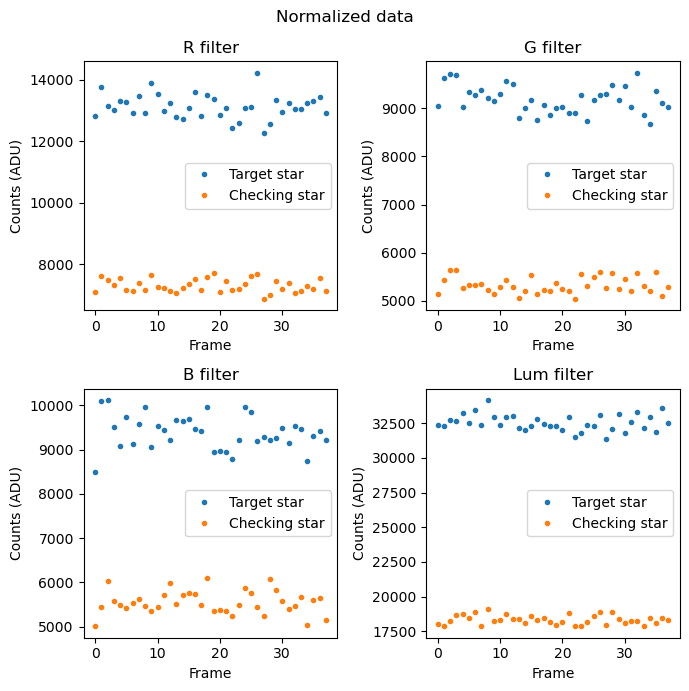

In [12]:
# displays normalised data

fig = figure(figsize=(7,7))
fig.suptitle("Normalized data")
figAxes = fig.add_subplot(2,2,1)
figAxes.plot(normR, "o", markersize=3)
figAxes.set_title("R filter")
figAxes.set_xlabel("Frame")
figAxes.set_ylabel("Counts (ADU)")
figAxes.legend(["Target star", "Checking star"])

figAxes = fig.add_subplot(2,2,2)
figAxes.plot(normG, "o", markersize=3)
figAxes.set_title("G filter")
figAxes.set_xlabel("Frame")
figAxes.set_ylabel("Counts (ADU)")
figAxes.legend(["Target star", "Checking star"])

figAxes = fig.add_subplot(2,2,3)
figAxes.plot(normB, "o", markersize=3)
figAxes.set_title("B filter")
figAxes.set_xlabel("Frame")
figAxes.set_ylabel("Counts (ADU)")
figAxes.legend(["Target star", "Checking star"])

figAxes = fig.add_subplot(2,2,4)
figAxes.plot(normLum, "o", markersize=3)
figAxes.set_title("Lum filter")
figAxes.set_xlabel("Frame")
figAxes.set_ylabel("Counts (ADU)")
figAxes.legend(["Target star", "Checking star"])

fig.tight_layout()
show()

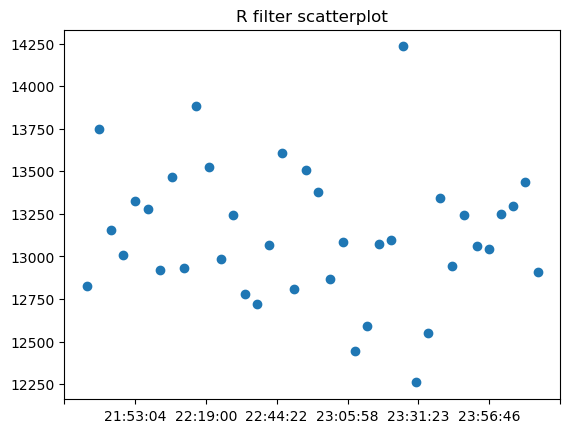

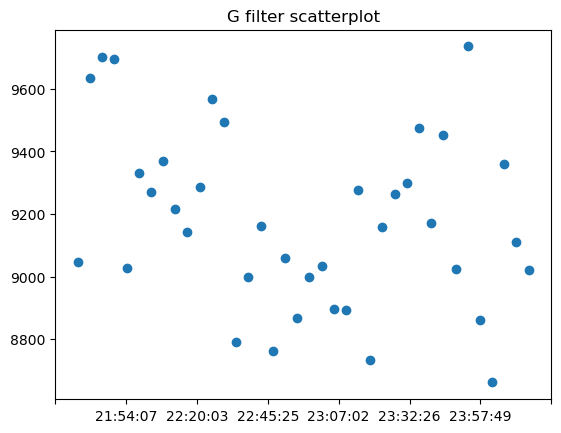

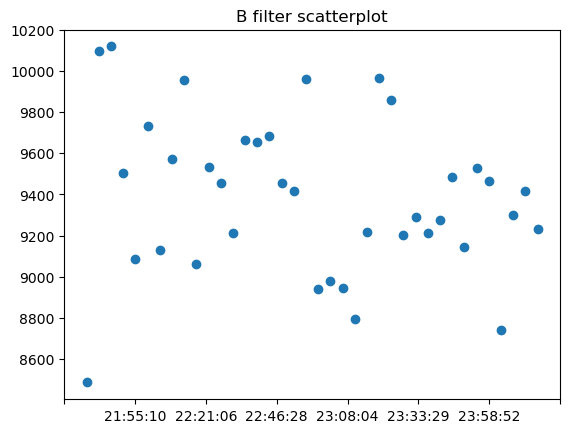

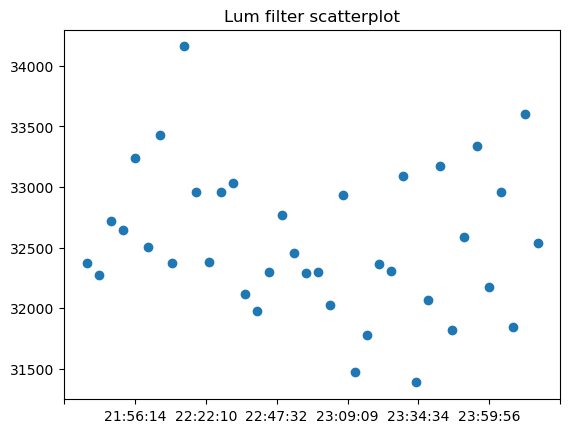

In [13]:
# displays normalised data for target star only
targetR = []
for i in range(0, len(normR)):
    targetR.append(normR[i][0])

#targetR, RT = SumFrames(targetR, RT)
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(RT, targetR)
figAxes.set_title("R filter scatterplot")
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))


targetG = []
for i in range(0, len(normG)):
    targetG.append(normG[i][0])

#targetG, GT = SumFrames(targetG, GT)
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(GT, targetG)
figAxes.set_title("G filter scatterplot")
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

targetB = []
for i in range(0, len(normB)):
    targetB.append(normB[i][0])
    
#targetB, BT = SumFrames(targetB, BT)
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(BT, targetB)
figAxes.set_title("B filter scatterplot")
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))


targetLum = []
for i in range(0, len(normLum)):
    targetLum.append(normLum[i][0])
    
#targetLum, LumT = SumFrames(targetLum, LumT)
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(LumT, targetLum)
figAxes.set_title("Lum filter scatterplot")
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))



In [14]:
# Finding Read noise for use in errors - similar code to that used in an assignment
# using janesick's method 
bias1list = fits.open("/net/virgo01/data/users/mpucovsky/OAProject/2025-05-05/LDST_250505-0001_BIAS3.fit")
bias2list = fits.open("/net/virgo01/data/users/mpucovsky/OAProject/2025-05-05/LDST_250505-0003_BIAS3.fit")
filters = ["R","G","B","Lum"]

# arrays use [R, G, B, Lum] order of data
filterFlats1 = []
filterFlats2 = []
for i in filters:
    filterFlats1.append(fits.open(f"/net/virgo01/data/users/mpucovsky/OAProject/2025-05-05/LDST_250505-0001_Flat{i}3.fit"))
    filterFlats2.append(fits.open(f"/net/virgo01/data/users/mpucovsky/OAProject/2025-05-05/LDST_250505-0003_Flat{i}3.fit"))


bias1data = bias1list[0].data
bias2data = bias2list[0].data

for i in range(0,4):
    filterFlats1[i] = (filterFlats1[i])[0].data.flatten()
    filterFlats2[i] = (filterFlats2[i])[0].data.flatten()
    
# finds biasdiff standard deviation
stdBiasdiff = bias1data.flatten().std() + bias2data.flatten().std()

# finds f
f = []
for i in range(0,4):
    f.append(np.median(filterFlats2[i])/np.median(filterFlats1[i]))

# finds median flatdiff
flatdiff = []
for i in range(0,4):
    flatdiff.append(np.median(filterFlats2[i]-f[i]*filterFlats1[i]))

# finds flatdiff standard deviation
stdFlatdiffs = []
for i in range(0,4):
    stdFlatdiff = 0
    for n in range(0,filterFlats1[i].size):
        stdFlatdiff += (((filterFlats2[i])[n]-f[i]*(filterFlats1[i])[n]) - flatdiff[i])**2 
    stdFlatdiff /= filterFlats1[i].size
    stdFlatdiffs.append(stdFlatdiff)

# finds gain in e-/ADU
bias1 = bias1data.flatten()
bias2 = bias2data.flatten()
gain = {}
for i in range(0,4):
    gain[filters[i]] = ((np.median(filterFlats2[i])-np.median(bias2)) + (f[i]**2)*(np.median(filterFlats1[i])-np.median(bias1)))/(stdFlatdiffs[i] - ((f[i]**2) + 1)*(stdBiasdiff/2))


# finds read noise in e-'s
stdReadnoise = stdBiasdiff/2
varReadnoise = np.sqrt(stdReadnoise)
readNoise = {}
for i in range(0,4):
    readNoise[filters[i]] = varReadnoise*gain[filters[i]]
print(gain)
print(readNoise)

{'R': 2.2100459130032655, 'G': 2.2009763872861066, 'B': 2.205530560669739, 'Lum': 2.2130524719066966}
{'R': 1.6459267476158843, 'G': 1.639172238635672, 'B': 1.6425639490708706, 'Lum': 1.6481658756305213}


In [15]:
# finds errors in each frame

def FindErr(file,fil):  
    data = orderedFrames[file]
    data += np.nanmedian(data) # accounts for global background
    # counts within target aperture
    tApStats = ap.ApertureStats(data, targetAp)
    tCounts = tApStats.sum*gain[fil]
    # read noise across entire aperture
    readCounts = tApStats.sum_aper_area.value*readNoise[fil]
    noise = (tCounts + readCounts**2)**0.5 # in e-
    noise /= gain[fil] # convert to ADU
    return noise

RErr = []
GErr = []
BErr = []
LumErr = []

for file in orderedFrames:
    if "R" in file[8:]:
        RErr.append(FindErr(file,"R"))
    if "G" in file[8:]:
        GErr.append(FindErr(file,"G"))
    if "B" in file[8:]:
        BErr.append(FindErr(file,"B"))
    if "Lum" in file[8:]:
        LumErr.append(FindErr(file,"Lum"))

#RErr, dummyTime = SumFrames(RErr, np.zeros(38))
#GErr, dummyTime = SumFrames(GErr, np.zeros(38))
#BErr, dummyTime = SumFrames(BErr, np.zeros(38))
#LumErr, dummyTime = SumFrames(LumErr, np.zeros(38))

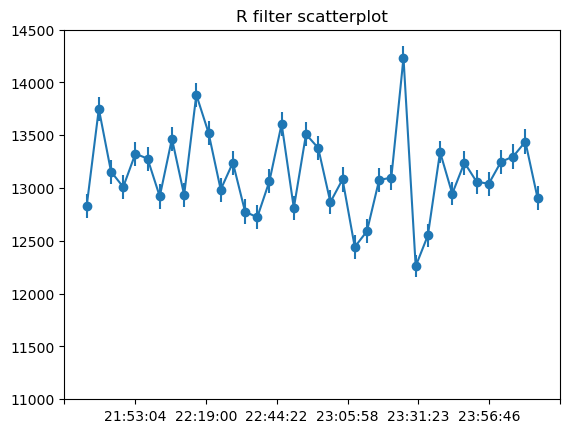

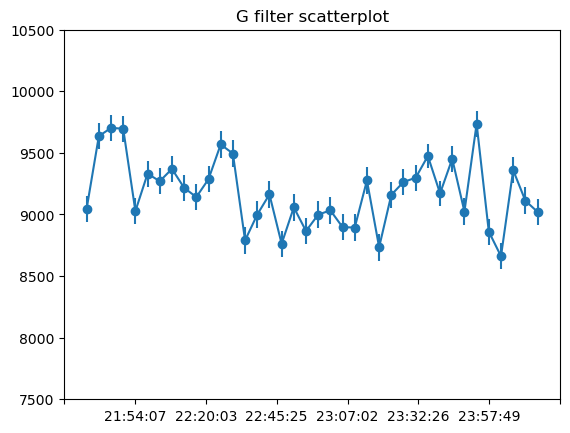

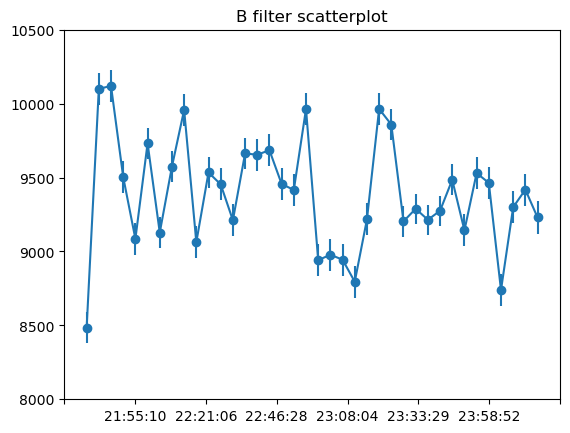

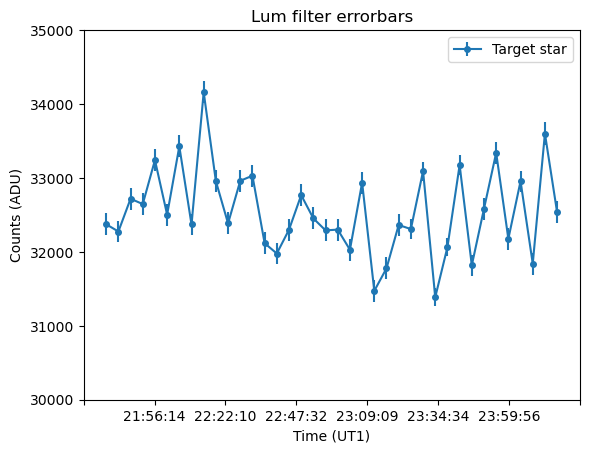

In [16]:
# displays normalised data for target star only, featuring error bars
    
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.errorbar(RT, targetR, RErr, marker='o')
figAxes.set_title("R filter scatterplot")
figAxes.set_ylim(11000, 14500)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

    
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.errorbar(GT, targetG, GErr, marker='o')
figAxes.set_title("G filter scatterplot")
figAxes.set_ylim(7500, 10500)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

    
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.errorbar(BT, targetB, BErr, marker='o')
figAxes.set_title("B filter scatterplot")
figAxes.set_ylim(8000, 10500)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

    
fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.errorbar(LumT, targetLum, LumErr, marker='o',markersize=4)
figAxes.set_title("Lum filter errorbars")
figAxes.set_xlabel("Time (UT1)")
figAxes.set_ylabel("Counts (ADU)")
figAxes.set_ylim(30000, 35000)
figAxes.legend(["Target star"])
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

show()


In [17]:
# creates models
# transit begins at UT1 22:21:00, ends at UT1 00:01:00
# transit has depth of 19.4 ppt
# alternate model based on apparent dip in data - begins at ~UT1 22:59:00, ends at ~UT1 23:32:00

# straight line models
lineR = np.full(38,np.mean(targetR))
lineG = np.full(38,np.mean(targetG))
lineB = np.full(38,np.mean(targetB))
lineLum = np.full(38,np.mean(targetLum))

# transit models
def FindModel(datas, times):
    data = np.asarray(datas)
    time = np.asarray(times)
    star = np.where(time < "22:21:00.000", data, np.nan)
    star = np.where(time < "24:01:00.000", star, data)
    starCounts = np.nanmean(star)
    dipCounts = starCounts*(1-0.0194)
    dip = np.where(time > "22:21:00.000", dipCounts, starCounts)
    dip = np.where(time < "24:01:00.000", dip, starCounts)
    return dip

dipR = FindModel(targetR,RT)
dipG = FindModel(targetG,GT)
dipB = FindModel(targetB,BT)
dipLum = FindModel(targetLum,LumT)

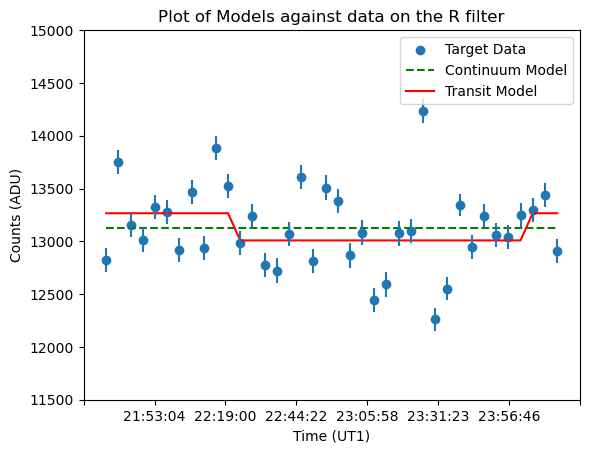

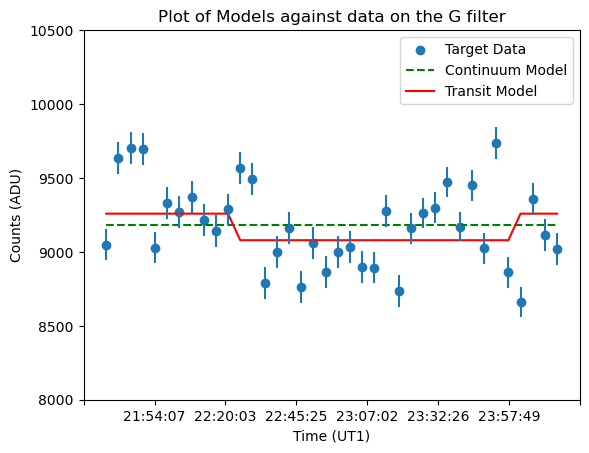

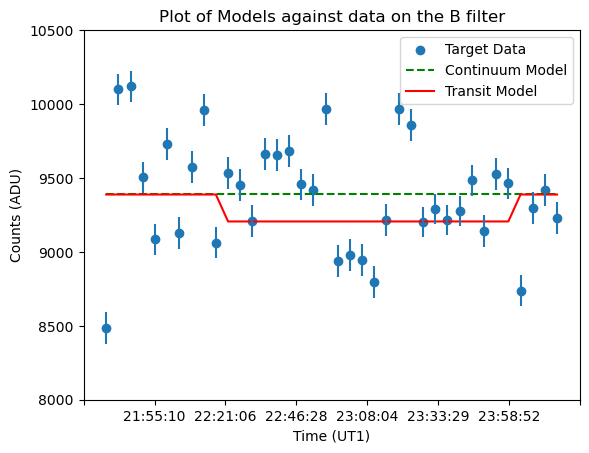

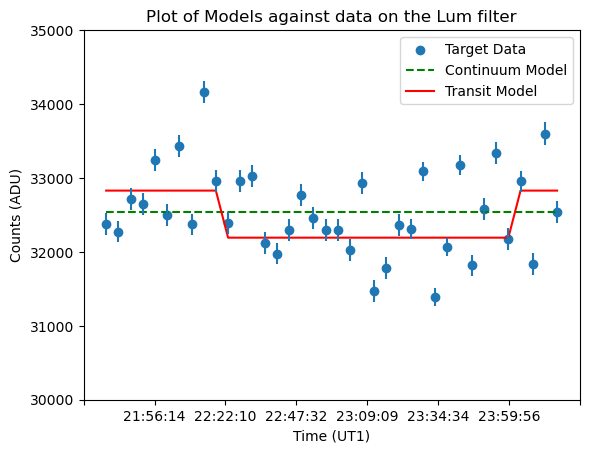

In [18]:
# plots data with errors and models

fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(RT, targetR)
figAxes.plot(RT, lineR, linestyle='dashed', color="green")
figAxes.plot(RT, dipR, color="red")
figAxes.errorbar(RT, targetR, RErr, fmt="none")
figAxes.legend(["Target Data", "Continuum Model", "Transit Model"])
figAxes.set_title("Plot of Models against data on the R filter")
figAxes.set_xlabel("Time (UT1)")
figAxes.set_ylabel("Counts (ADU)")
figAxes.set_ylim(11500, 15000)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(GT, targetG)
figAxes.plot(GT, lineG, linestyle='dashed', color="green")
figAxes.plot(GT, dipG, color="red")
figAxes.errorbar(GT, targetG, GErr, fmt="none")
figAxes.legend(["Target Data", "Continuum Model", "Transit Model"])
figAxes.set_title("Plot of Models against data on the G filter")
figAxes.set_xlabel("Time (UT1)")
figAxes.set_ylabel("Counts (ADU)")
figAxes.set_ylim(8000, 10500)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(BT, targetB)
figAxes.plot(BT, lineB, linestyle='dashed', color="green")
figAxes.plot(BT, dipB, color="red")
figAxes.errorbar(BT, targetB, BErr, fmt="none")
figAxes.legend(["Target Data", "Continuum Model", "Transit Model"])
figAxes.set_title("Plot of Models against data on the B filter")
figAxes.set_xlabel("Time (UT1)")
figAxes.set_ylabel("Counts (ADU)")
figAxes.set_ylim(8000, 10500)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

fig = figure()
figAxes = fig.add_subplot(1,1,1)
figAxes.scatter(LumT, targetLum)
figAxes.plot(LumT, lineLum, linestyle='dashed', color="green")
figAxes.plot(LumT, dipLum, color="red")
figAxes.errorbar(LumT, targetLum, LumErr, fmt="none")
figAxes.legend(["Target Data", "Continuum Model", "Transit Model"])
figAxes.set_title("Plot of Models against data on the Lum filter")
figAxes.set_xlabel("Time (UT1)")
figAxes.set_ylabel("Counts (ADU)")
figAxes.set_ylim(30000, 35000)
figAxes.xaxis.set_major_locator(ticker.LinearLocator(8))

In [19]:
# chisquare tests
def ReducedChisquare(observation,model,err,var):
    obs = np.asarray(observation)
    model = np.asarray(model)
    err = np.asarray(err)
    redChisquare = np.sum(((obs-model)/err)**2)/(obs.size-var)
    return redChisquare

# Chisquare results
print(f"R filter: {ReducedChisquare(targetR,dipR,RErr,4) - ReducedChisquare(targetR,lineR,RErr,1)}")
print(f"G filter: {ReducedChisquare(targetG,dipG,GErr,4) - ReducedChisquare(targetG,lineG,GErr,1)}")
print(f"B filter: {ReducedChisquare(targetB,dipB,BErr,4) - ReducedChisquare(targetB,lineB,BErr,1)}")
print(f"Lum filter: {ReducedChisquare(targetLum,dipLum,LumErr,4) - ReducedChisquare(targetLum,lineLum,LumErr,1)}")


R filter: 0.24312317798412053
G filter: 0.4257547580563914
B filter: 3.1577684239873225
Lum filter: 0.09224274145337574
